<a href="https://colab.research.google.com/github/Ajay-user/DataScience/blob/master/Notes/Transfer_learning_and_Fine_tuning_guide.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [46]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

## Workflow
https://www.tensorflow.org/guide/keras/transfer_learning#transfer_learning_fine-tuning_with_a_custom_training_loop

**The typical transfer-learning workflow**


* Instantiate a base model and load pre-trained weights into it.
* Freeze all layers in the base model by setting `trainable = False`.
* Create a new model on top of the pre-trained model.
* Train your new model on your new dataset.

**Note that an alternative, more lightweight workflow**

* Instantiate a base model and load pre-trained weights into it.
* Run your new dataset through it and record the output of the pre-trained model. This is called **feature extraction**.
* Use that output as input data for a new, smaller model.
* A key advantage of that second workflow is that you only run the base model once on your data, rather than once per epoch of training. So it's a lot faster & cheaper.

* An issue with that second workflow, though, is that it doesn't allow you to dynamically modify the input data of your new model during training

Data augmentationis required when dataset is small , for instance. Transfer learning is typically used for tasks when your new dataset has too little data to train a full-scale model from scratch, and in such scenarios data augmentation is very important.

**Freezing layers: understanding the trainable attribute**

Layers & models have three weight attributes:

* `weights` is the list of all weights variables of the layer.
* `trainable_weight`s is the list of those that are meant to be updated (via gradient descent) to minimize the loss during training.
* `non_trainable_weights` is the list of those that aren't meant to be trained. Typically they are updated by the model during the forward pass.

**The Dense layer has 2 trainable weights (kernel & bias)**


In general, all weights are trainable weights. The only built-in layer that has non-trainable weights is the `BatchNormalization layer`. **It uses non-trainable weights to keep track of the mean and variance of its inputs during training**.

**The BatchNormalization layer has 2 trainable weights and 2 non-trainable weights**

Layers & models also feature a boolean attribute `trainable`. Its value can be changed. Setting layer.trainable to False moves all the layer's weights from trainable to non-trainable. This is called "freezing" the layer: the state of a frozen layer won't be updated during training (either when training with fit() or when training with any custom loop that relies on trainable_weights to apply gradient updates).

**Recursive setting of the trainable attribute**

If you set `trainable = False` on a model or on any layer that has sublayers, all children layers become non-trainable as well.

When a trainable weight becomes non-trainable, its value is no longer updated during training.

Do not confuse the `layer.trainable` attribute with the argument training in `layer.__call__()` (which controls whether the layer should run its forward pass in inference mode or training mode).

## Import the dataset

In [3]:
(raw_train_ds, raw_val_ds, raw_test_ds), metadata = tfds.load('cats_vs_dogs',
                                                  split=['train[:40%]','train[40%:50%]','train[50%:60%]'],
                                                  as_supervised=True,
                                                   with_info=True)

Shuffling and writing examples to /root/tensorflow_datasets/cats_vs_dogs/4.0.0.incomplete6JL37M/cats_vs_dogs-train.tfrecord


Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.


In [21]:
print('Number of training samples',raw_train_ds.cardinality().numpy())
print('Number of validation samples',raw_val_ds.cardinality().numpy())
print('Number of testing samples',raw_test_ds.cardinality().numpy())

Number of training samples 9305
Number of validation samples 2326
Number of testing samples 2326


We Cannot batch tensors with different shapes in component 0. 

for eg :  First element had shape `[262,350,3]` and element 1 had shape `[409,336,3]`.

Here the raw images have a variety of sizes. In addition, each pixel consists of 3 integer values between 0 and 255 (RGB level values). This isn't a great fit for feeding a neural network. We need to do 2 things:

* Standardize to a fixed image size. We pick 150x150.
* Rescale the pixel values between -1 and 1.

In [22]:
train_ds = raw_train_ds.map(lambda x,y: (tf.image.resize(x, size=(150,150)),y))
val_ds = raw_val_ds.map(lambda x,y: (tf.image.resize(x, size=(150,150)),y))
test_ds = raw_test_ds.map(lambda x,y: (tf.image.resize(x, size=(150,150)),y))

## Optimize the input

In [23]:
def config_for_optimization(ds):
  ds = ds.batch(32)
  ds = ds.prefetch(tf.data.AUTOTUNE)
  return ds

In [24]:
train_ds = config_for_optimization(train_ds)
val_ds = config_for_optimization(val_ds)
test_ds = config_for_optimization(test_ds)

## Preprocessing

In [25]:
resize = tf.keras.layers.experimental.preprocessing.Resizing(150,150)
rescale = tf.keras.layers.experimental.preprocessing.Rescaling(scale=1.0/127.5, offset=-1)
# we can use the preprocess_input method that comes with the model too
preprocess_input = tf.keras.applications.xception.preprocess_input

## Data-augmentation

In [26]:
data_augmentation = tf.keras.Sequential([
                                         tf.keras.layers.experimental.preprocessing.RandomFlip(),
                                         tf.keras.layers.experimental.preprocessing.RandomRotation(0.2)
])

## Global average pooling

In [27]:
global_avg = tf.keras.layers.GlobalAveragePooling2D()

## Prediction layer

In [28]:
prediction_layer = tf.keras.layers.Dense(1)

## Convolution base

In [29]:
base_model = tf.keras.applications.Xception(include_top=False, weights='imagenet', input_shape=(150,150,3))

### Freeze the pre-trained model

In [30]:
base_model.trainable= False

## Build a model

Make sure to pass `training=False` when calling the base model, so that it runs in inference mode, so that batchnorm statistics don't get updated even after we unfreeze the base model for fine-tuning.

In [31]:
# input layer
inputs = tf.keras.layers.Input(shape=(150,150,3))
# preprocessing - rescale
x = preprocess_input(inputs)
# data-augmentation
x = data_augmentation(x)
# pretrained model -- inference mode
x = base_model(x, training=False)
# global-average-pooling
x = global_avg(x)
# drop-out-layer
x = tf.keras.layers.Dropout(0.2)(x)
# classifier
outputs = prediction_layer(x)

model = tf.keras.Model(inputs, outputs)

## Compile the model

In [32]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [33]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
tf.math.truediv_1 (TFOpLambd (None, 150, 150, 3)       0         
_________________________________________________________________
tf.math.subtract_1 (TFOpLamb (None, 150, 150, 3)       0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 150, 150, 3)       0         
_________________________________________________________________
xception (Functional)        (None, 5, 5, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0   

## Early stopping callback

In [34]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=1, restore_best_weights=True)

## Training 

In [35]:
history = model.fit(train_ds,
                    epochs=10,
                    validation_data=val_ds,
                    callbacks=[early_stopping])

Epoch 1/10
291/291 [==============================] - 889s 3s/step - loss: 0.5440 - accuracy: 0.7006 - val_loss: 0.2428 - val_accuracy: 0.9205
Epoch 2/10
291/291 [==============================] - 883s 3s/step - loss: 0.3667 - accuracy: 0.8207 - val_loss: 0.1707 - val_accuracy: 0.9463
Epoch 3/10
291/291 [==============================] - 876s 3s/step - loss: 0.3238 - accuracy: 0.8460 - val_loss: 0.1453 - val_accuracy: 0.9527
Epoch 4/10
291/291 [==============================] - 882s 3s/step - loss: 0.3068 - accuracy: 0.8547 - val_loss: 0.1310 - val_accuracy: 0.9613
Epoch 5/10
291/291 [==============================] - 878s 3s/step - loss: 0.2887 - accuracy: 0.8678 - val_loss: 0.1229 - val_accuracy: 0.9617
Epoch 6/10
291/291 [==============================] - 884s 3s/step - loss: 0.2779 - accuracy: 0.8715 - val_loss: 0.1180 - val_accuracy: 0.9622
Epoch 7/10
291/291 [==============================] - 877s 3s/step - loss: 0.2707 - accuracy: 0.8766 - val_loss: 0.1139 - val_accuracy: 0.9626

## Evaluation

In [36]:
loss, accuracy = model.evaluate(test_ds)
print('Loss',loss)
print('Accuracy',accuracy)

73/73 [==============================] - 173s 2s/step - loss: 0.1071 - accuracy: 0.9600
Loss 0.10712040960788727
Accuracy 0.960017204284668


## Fine tuning


* Once your model has converged on the new data, you can try to unfreeze all or part of the base model and **retrain the whole model end-to-end with a very low learning rate**.

* This is an optional last step that can potentially give you incremental improvements. **It could also potentially lead to quick overfitting** -- keep that in mind.

* **It is critical to only do this step after the model with frozen layers has been trained to convergence**. If you mix randomly-initialized trainable layers with trainable layers that hold pre-trained features, the randomly-initialized layers will cause very large gradient updates during training, which will destroy your pre-trained features.

*  **It's also critical to use a very low learning rate at this stage**, because you are training a much larger model than in the first round of training, on a dataset that is typically very small. As a result, **you are at risk of overfitting very quickly if you apply large weight updates**. Here, you only want to readapt the pretrained weights in an incremental way.



### Unfreeze the pretrained model

Unfreeze the base model and train the entire model end-to-end with a low learning rate.

Importantly, although the base model becomes trainable, it is still running in inference mode since we passed training=False when calling it when we built the model. This means that the batch normalization layers inside won't update their batch statistics. If they did, they would wreck havoc on the representations learned by the model so far.

In [37]:
base_model.trainable = True

In [39]:
print('Number of layers in pre-trained model',len(base_model.layers))

Number of layers in pre-trained model 132


In [40]:
# we don't to train all the layers
# we only want to train the top-level-layers to adapt dataset specific features

fine_tune = 80

for base_layer in base_model.layers[:fine_tune]:
  base_layer.trainable = False

## Compile the Model

**Important note about compile() and trainable**

* Calling `compile()` on a model is meant to "freeze" the behavior of that model. This implies that the trainable attribute values at the time the model is compiled should be preserved throughout the lifetime of that model, until compile is called again. Hence, if you change any trainable value, make sure to call `compile()` again on your model for your changes to be taken into account.

**Important notes about BatchNormalization layer**

* BatchNormalization contains 2 non-trainable weights that get updated during training. These are the variables tracking the mean and variance of the inputs.
* When you set `bn_layer.trainable = False`, the BatchNormalization layer will run in inference mode, and will not update its mean & variance statistics. This is not the case for other layers in general, as weight trainability & inference/training modes are two orthogonal concepts. But the two are tied in the case of the BatchNormalization layer.
* When you unfreeze a model that contains BatchNormalization layers in order to do fine-tuning, you should keep the BatchNormalization layers in inference mode by passing `training=False` when calling the base model. Otherwise the updates applied to the non-trainable weights will suddenly destroy what the model has learned.

In [41]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [42]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
tf.math.truediv_1 (TFOpLambd (None, 150, 150, 3)       0         
_________________________________________________________________
tf.math.subtract_1 (TFOpLamb (None, 150, 150, 3)       0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 150, 150, 3)       0         
_________________________________________________________________
xception (Functional)        (None, 5, 5, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0   

## Training

In [43]:
fine_tune_history = model.fit(train_ds,
                              epochs=20,
                              validation_data=val_ds,
                              initial_epoch=history.epoch[-1],
                              callbacks=[early_stopping])

Epoch 10/20
291/291 [==============================] - 1746s 6s/step - loss: 0.2306 - accuracy: 0.8979 - val_loss: 0.0786 - val_accuracy: 0.9708
Epoch 11/20
291/291 [==============================] - 1788s 6s/step - loss: 0.1820 - accuracy: 0.9203 - val_loss: 0.0796 - val_accuracy: 0.9708


## Evaluation

In [44]:
loss, accuracy = model.evaluate(test_ds)
print('Loss',loss)
print('Accuracy',accuracy)

73/73 [==============================] - 174s 2s/step - loss: 0.0879 - accuracy: 0.9635
Loss 0.08791561424732208
Accuracy 0.9634565711021423


## Learning curves

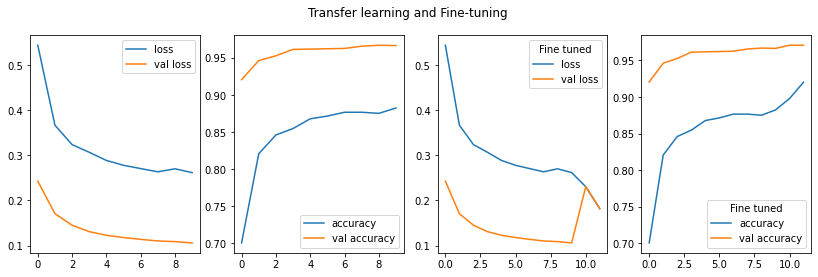

In [48]:
plt.figure(figsize=(14,4))

plt.subplot(1,4,1)
plt.plot(range(10), history.history['loss'], label='loss')
plt.plot(range(10), history.history['val_loss'], label='val loss')
plt.legend()
plt.subplot(1,4,2)
plt.plot(range(10), history.history['accuracy'], label='accuracy')
plt.plot(range(10), history.history['val_accuracy'], label='val accuracy')
plt.legend()
# model after fine tuning
plt.subplot(1,4,3)
plt.plot(range(12), (history.history['loss']+fine_tune_history.history['loss']), label='loss')
plt.plot(range(12), (history.history['val_loss']+fine_tune_history.history['loss']), label='val loss')
plt.legend(title='Fine tuned')
plt.subplot(1,4,4)
plt.plot(range(12), (history.history['accuracy']+fine_tune_history.history['accuracy']), label='accuracy')
plt.plot(range(12), (history.history['val_accuracy']+fine_tune_history.history['val_accuracy']), label='val accuracy')
plt.legend(title='Fine tuned')


plt.suptitle('Transfer learning and Fine-tuning')

plt.show()